In [15]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import random

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

In [16]:
# Load CSV data into a DataFrame

data_path = "../data/data.csv"
columns = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 
           'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 
           'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 
           'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 
           'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 
           'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 
           'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 
           'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 
           'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'label']

df = pd.read_csv(data_path, header=None, names=columns)
print("Dataset shape:", df.shape)
df.head()
label_counts = df['label'].value_counts()
print(label_counts)


Dataset shape: (4898431, 42)
label
smurf.              2807886
neptune.            1072017
normal.              972781
satan.                15892
ipsweep.              12481
portsweep.            10413
nmap.                  2316
back.                  2203
warezclient.           1020
teardrop.               979
pod.                    264
guess_passwd.            53
buffer_overflow.         30
land.                    21
warezmaster.             20
imap.                    12
rootkit.                 10
loadmodule.               9
ftp_write.                8
multihop.                 7
phf.                      4
perl.                     3
spy.                      2
Name: count, dtype: int64


1. Preprocessing

Now I will classify two different type of data, categorical and continous. This is because each type of data have 
different way of encoding it. So we will encode it differently, then concat it to create a token that represent a row of
data.

In [17]:
categorical_cols = ['protocol_type', 'service', 'flag', 'land', 'logged_in', 'is_host_login', 'is_guest_login']
continuous_cols = [col for col in df.columns if col not in categorical_cols + ['label']]

In [18]:
#For continuous data, we will use normalisation 
scaler = StandardScaler()
df_cont = pd.DataFrame(scaler.fit_transform(df[continuous_cols]), columns=continuous_cols)

In [19]:
#For categorical data, since they r text, we will use label encoder
df_cat = df[categorical_cols].copy()
cat_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_cat[col] = le.fit_transform(df_cat[col].astype(str))
    cat_encoders[col] = le

In [20]:
#Preprocessing the label
# Process target labels: first remove trailing punctuation if any (e.g., "normal." -> "normal")
df['label'] = df['label'].str.replace(r'\W+$', '', regex=True)
target_labels = ['back', 'buffer_overflow', 'ftp_write', 'guess_passwd', 'imap', 'ipsweep', 'land', 
                 'loadmodule', 'multihop', 'neptune', 'nmap', 'normal', 'perl', 'phf', 'pod', 'portsweep', 
                 'rootkit', 'satan', 'smurf', 'spy', 'teardrop', 'warezclient', 'warezmaster']


In [21]:
# Create label encoder for targets
target_le = LabelEncoder()
target_le.fit(target_labels)
df['label_enc'] = target_le.transform(df['label'])
print(target_le.classes_)



['back' 'buffer_overflow' 'ftp_write' 'guess_passwd' 'imap' 'ipsweep'
 'land' 'loadmodule' 'multihop' 'neptune' 'nmap' 'normal' 'perl' 'phf'
 'pod' 'portsweep' 'rootkit' 'satan' 'smurf' 'spy' 'teardrop'
 'warezclient' 'warezmaster']


In [22]:
# Combine continuous and categorical features
df_features = pd.concat([df_cont, df_cat], axis=1)
print("Processed features shape:", df_features.shape)
df_features.head()

Processed features shape: (4898431, 41)


,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,root_shell,su_attempted,...,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,protocol_type,service,flag,land,logged_in,is_host_login,is_guest_login
0,-0.066833,-0.001720,0.068188,-0.015139,-0.001103,-0.026521,-0.004391,-0.002097,-0.008258,-0.004546,...,-0.465454,-0.250832,-0.249632,1,24,9,0,1,0,0
1,-0.066833,-0.001777,0.005325,-0.015139,-0.001103,-0.026521,-0.004391,-0.002097,-0.008258,-0.004546,...,-0.465454,-0.250832,-0.249632,1,24,9,0,1,0,0
2,-0.066833,-0.001698,0.000208,-0.015139,-0.001103,-0.026521,-0.004391,-0.002097,-0.008258,-0.004546,...,-0.465454,-0.250832,-0.249632,1,24,9,0,1,0,0
3,-0.066833,-0.001701,0.001455,-0.015139,-0.001103,-0.026521,-0.004391,-0.002097,-0.008258,-0.004546,...,-0.465454,-0.250832,-0.249632,1,24,9,0,1,0,0
4,-0.066833,-0.001695,-0.000942,-0.015139,-0.001103,-0.026521,-0.004391,-0.002097,-0.008258,-0.004546,...,-0.465454,-0.250832,-0.249632,1,24,9,0,1,0,0


2. Create the model

My intention is using a transformer that have similar structure to BERT. This is because the model will have an attention layer to learn the semantic relationship between packets. The sliding allows
use to look at a range of packets in sequence, and look if there is suspicious packets in the sequence.

In [ ]:
WINDOW_SIZE = 100
class SlidingWindowDataset(Dataset):
    def __init__(self, features, labels, window_size):
        """
        features: numpy array of shape (num_rows, num_features)
        labels: numpy array of shape (num_rows,)
        window_size: int, number of rows per window
        """
        self.features = features
        self.labels = labels
        self.window_size = window_size
        self.num_samples = len(features) - window_size + 1  # number of sliding windows
        
    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        # Extract a window of consecutive rows on the fly
        window = self.features[idx : idx + self.window_size]
        # For simplicity, we use the label of the last row in the window. It means that if there is a bad packet in the end of the sequence,
        #the model will immediately flag entire sequence as bad as soon as a bad packet comes in
        label = self.labels[idx + self.window_size - 1]
        return torch.tensor(window, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

# Get the preprocessed feature and label arrays
features_np = df_features.values.astype(np.float32)
labels_np = df['label_enc'].values.astype(np.int64)
print("Original features shape:", features_np.shape)
print("Original labels shape:", labels_np.shape)

# Create the sliding window dataset
dataset = SlidingWindowDataset(features_np, labels_np, WINDOW_SIZE)
print("Sliding window dataset length:", len(dataset))

# Split the dataset into training and test sets using random_split
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

Original features shape: (4898431, 41)
Original labels shape: (4898431,)
Sliding window dataset length: 4898332


In [24]:
class PacketTransformer(nn.Module):
    def __init__(self, input_dim, embed_dim, num_layers, num_heads, window_size, num_classes):
        super(PacketTransformer, self).__init__()
        self.window_size = window_size
        
        # Project the input token (each row) into an embedding
        self.input_proj = nn.Linear(input_dim, embed_dim)
        
        # [CLS] token embedding (learnable)
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        
        # Positional embeddings: one per token in the window (+1 for [CLS])
        self.pos_embedding = nn.Parameter(torch.randn(window_size + 1, embed_dim))
        
        # Transformer encoder layers
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dropout=0.1)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.ReLU(),
            nn.Linear(embed_dim, num_classes)
        )
        
    def forward(self, x):
        """
        x: tensor of shape [batch, window_size, input_dim]
        """
        batch_size = x.size(0)
        # Project each token
        tokens = self.input_proj(x)  # [batch, window_size, embed_dim]
        
        # Prepend [CLS] token for each sample in the batch
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)  # [batch, 1, embed_dim]
        tokens = torch.cat([cls_tokens, tokens], dim=1)  # [batch, window_size+1, embed_dim]
        
        # Add positional embedding
        tokens = tokens + self.pos_embedding.unsqueeze(0)
        
        # Transformer expects shape: [seq_len, batch, embed_dim]
        tokens = tokens.transpose(0, 1)
        transformer_out = self.transformer_encoder(tokens)
        
        # Use [CLS] token output for classification (first token)
        cls_out = transformer_out[0]  # [batch, embed_dim]
        logits = self.classifier(cls_out)
        return logits

In [25]:
input_dim = dataset.features.shape[-1]#X_Windows.shape[-1] #df_features.shape[-1]  # number of features per token
embed_dim = 64
num_layers = 2
num_heads = 4
num_classes = len(target_labels)
num_epochs = 5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = PacketTransformer(input_dim=input_dim, embed_dim=embed_dim, num_layers=num_layers,
                          num_heads=num_heads, window_size=WINDOW_SIZE, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

Using device: cuda


c:\Users\Antoi\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [26]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    # Wrap loader with tqdm for progress bar
    for batch_X, batch_y in tqdm(loader, desc="Training", leave=False):
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        logits = model(batch_X)
        loss = criterion(logits, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * batch_X.size(0)
    return running_loss / len(loader.dataset)

In [27]:
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    all_preds = []
    all_labels = []
    
    # Wrap loader with tqdm for progress bar during evaluation
    for batch_X, batch_y in tqdm(loader, desc="Evaluating", leave=False):
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        logits = model(batch_X)
        loss = criterion(logits, batch_y)
        running_loss += loss.item() * batch_X.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == batch_y).sum().item()
        # Collect predictions and true labels for confusion matrix
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())
        
    avg_loss = running_loss / len(loader.dataset)
    avg_acc = correct / len(loader.dataset)
    return avg_loss, avg_acc, all_labels, all_preds

In [28]:
for epoch in range(1, num_epochs+1):
    print(f"Epoch {epoch}/{num_epochs}")
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, all_labels, all_preds = evaluate(model, test_loader, criterion, device)

    
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

Epoch 1/5


Train Loss: 0.0139 | Val Loss: 0.0071 | Val Acc: 0.9984
Epoch 2/5


Train Loss: 0.0057 | Val Loss: 0.0057 | Val Acc: 0.9988
Epoch 3/5


Train Loss: 0.0053 | Val Loss: 0.0036 | Val Acc: 0.9992
Epoch 4/5


Train Loss: 0.0044 | Val Loss: 0.0061 | Val Acc: 0.9986
Epoch 5/5


Train Loss: 0.0043 | Val Loss: 0.0048 | Val Acc: 0.9991


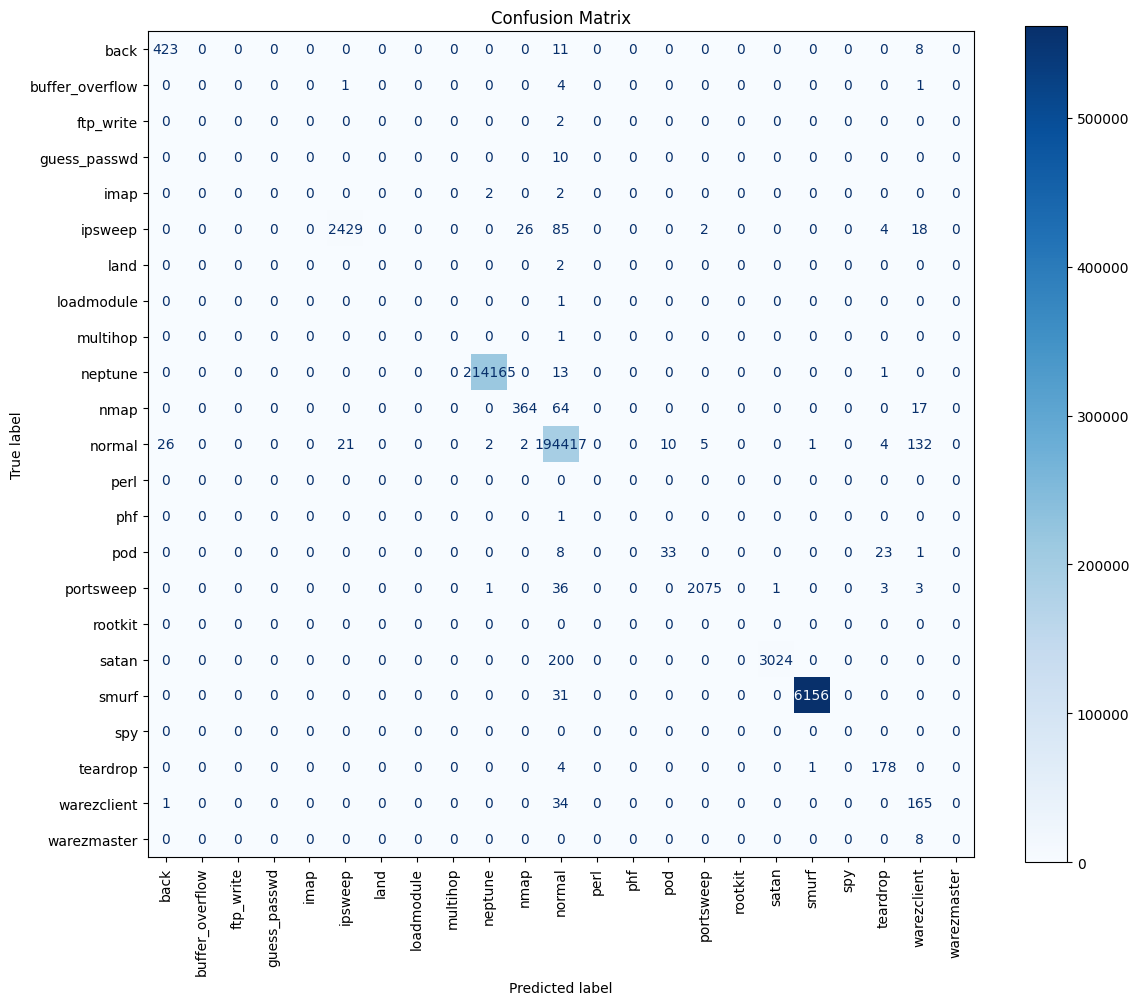

In [ ]:
#colour scale is currently a bit strange

def compute_confusion_matrix(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch_X, batch_y in loader:
            batch_X = batch_X.to(device)
            logits = model(batch_X)
            preds = logits.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(batch_y.cpu().numpy())
    return all_labels, all_preds

# Compute confusion matrix on test data
true_labels, pred_labels = compute_confusion_matrix(model, test_loader, device)
cm = confusion_matrix(all_labels, all_preds, labels=list(range(len(target_labels))))

# Create a larger figure
fig, ax = plt.subplots(figsize=(12, 10))  # Adjust width=12, height=10 as needed

# Pass 'ax=ax' to plot the confusion matrix on this figure
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_labels)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical', ax=ax)

plt.title("Confusion Matrix")
plt.tight_layout()  # Helps reduce label overlap
plt.show()